# 3 . Load and Preprocess Images

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import Model  # Model(input = [inputImage,verificationImage],output = [1,0])
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, Input
import tensorflow as tf

In [4]:
from cProfile import label

import tensorflow as tf
from tensorflow.python.ops.image_ops_impl import ResizeMethod

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    name = tf.config.experimental.get_device_details(gpus[0]).get("device_name", "Unknown")
    print("CUDA available: True")
    print("GPU Name:", name)
else:
    print("CUDA available: False")
    print("GPU: No GPU")


TensorFlow version: 2.20.0
CUDA available: True
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [5]:
# Setup Paths
POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

### 3.1 get Images

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + "/*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + "/*.jpg").take(300)

# but in windows use "\*.jpg"

# this is works on cross-platform
# import os
# anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)


I0000 00:00:1761965574.439130    7683 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
dir_test = anchor.as_numpy_iterator()

In [6]:
# give the next file in interation this is flexible
print(dir_test.next())

b'data/anchor/f3eef52c-9cd9-11f0-b546-581122864d18.jpg'


### 3.2 Preprocessing -scale and resize

In [8]:
# creating function for preprocess
def preprocess(file_path):
    # Reading image from the file path
    byte_img = tf.io.read_file(file_path)
    # decode/load the images return unit8(int8)
    img = tf.io.decode_jpeg(byte_img)
    # resize the image to 100,100,3 and return the float32 type so no neet typecast
    img = tf.image.resize(img, (100, 100))
    # divide the image by 255 because get all the value to between (0-1)
    # this is use less because resize func is return the float32
    # img = tf.image.convert_image_dtype(img, tf.float32)
    img = img / 255.0

    return img

<details>
<summary><b>TensorFlow Image Preprocessing Function</b></summary>

```python
import tensorflow as tf

def preprocess_image(image_path, img_height=224, img_width=224):
    """
    Load and preprocess an image from a file path.

    Parameters:
    - image_path: string, path to the image file.
    - img_height: int, desired height of the output image.
    - img_width: int, desired width of the output image.

    Returns:
    - image: Tensor, preprocessed image tensor of shape (img_height, img_width, 3)
             with pixel values normalized to [0, 1].
    """

    # 1. Load image from file as raw bytes
    image = tf.io.read_file(image_path)

    # 2. Decode image bytes into a uint8 tensor (JPEG with 3 channels)
    image = tf.image.decode_jpeg(image, channels=3)

    # 3. Convert uint8 pixel values [0, 255] to float32 [0.0, 1.0]
    image = tf.image.convert_image_dtype(image, tf.float32)

    # 4. Resize image to the target size
    image = tf.image.resize(image, [img_height, img_width])

    # 5. (Optional) Data augmentation - uncomment to enable
    # image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_brightness(image, max_delta=0.1)
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # 6. (Optional) Normalize image with dataset-specific mean and std
    # imagenet_mean = tf.constant([0.485, 0.456, 0.406])
    # imagenet_std = tf.constant([0.229, 0.224, 0.225])
    # image = (image - imagenet_mean) / imagenet_std

    return image
```

</details>

---

<details>
<summary><b>Explanation of Each Step</b></summary>

| Step | What it does                                                        | Why it’s important                                        |
| ---- | ------------------------------------------------------------------- | --------------------------------------------------------- |
| 1    | Reads the image file from disk as raw bytes                         | Necessary to load image data                              |
| 2    | Decodes the image bytes into a tensor (uint8)                       | Converts bytes to an image tensor                         |
| 3    | Converts pixel values from `[0, 255]` uint8 to `[0.0, 1.0]` float32 | Neural networks work better with normalized inputs        |
| 4    | Resizes image to fixed dimensions (e.g., 224x224)                   | Most models require fixed input sizes                     |
| 5    | Optional augmentation (flip, brightness, contrast)                  | Helps prevent overfitting by increasing data diversity    |
| 6    | Optional normalization to zero-mean and unit-variance               | Required by many pretrained models for better performance |

</details>

---

<details>
<summary><b>Usage Example</b></summary>

```python
image_tensor = preprocess_image("path/to/image.jpg", 224, 224)

# Add batch dimension for feeding into model (batch_size=1)
image_batch = tf.expand_dims(image_tensor, axis=0)
print(image_batch.shape)  # (1, 224, 224, 3)
```

</details>

---

<details>
<summary><b>Additional Notes</b></summary>

* Use the appropriate decode function for your image format:

  * `tf.image.decode_jpeg()` for JPEG images
  * `tf.image.decode_png()` for PNG images

* When enabling normalization (step 6), use the correct means/std for your dataset or pretrained model.

* Data augmentation (step 5) is typically used during **training only**, not during validation/testing.

---

If you want, I can also help you **expand this into a full TensorFlow data pipeline** or add **more advanced augmentations**!

</details>

---


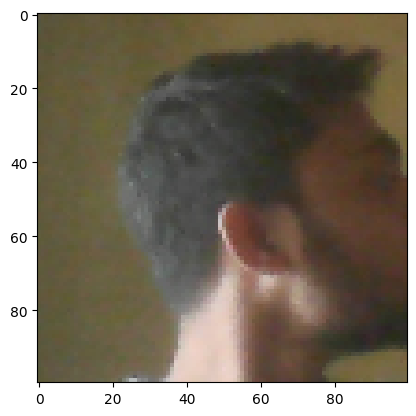

In [10]:
plt.imshow(preprocess("data/anchor/f7af0b15-9cd9-11f0-8bf0-581122864d18.jpg"))

### 3.3 Create Labelled Dataset

In [17]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [29]:
# check the samples are exist or not
samples_next = data.as_numpy_iterator()

print("Positives \t:",len(positives))
print("Negatives \t:",len(negatives))
print("Total \t\t:",len(data))

for sample in samples_next:
    label = sample[2]
    if label == 0.0:
        print("Negative sample found:", sample)
        break
else:
    print("No negative samples found")


Positives 	: 300
Negatives 	: 300
Total 		: 600
Negative sample found: (b'data/anchor/f73eca15-9cd9-11f0-a4a4-581122864d18.jpg', b'data/negative/Renee_Zellweger_0015.jpg', np.float32(0.0))


In [30]:
samples = data.as_numpy_iterator()

In [31]:
examples = samples.next()

### 3.4 Build Train and Test partition

In [35]:
def preprocess_twin(input_img, validation_img, labels):
    return preprocess(input_img), preprocess(validation_img), labels

In [39]:
res = preprocess_twin(*examples)

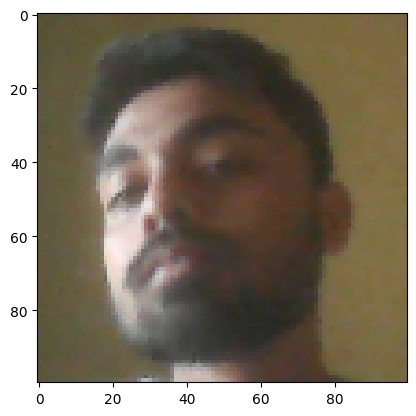

In [40]:
plt.imshow(res[0])

In [17]:
# Build dataloader Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [18]:
# Training partition
train_data = data.take(round(len(data) * 0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [19]:
# Testing partition
test_data = data.skip(round(len(data) * 0.7))
test_data = test_data.take(round(len(data) * 0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model building

### 4.1 building embedding layer

In [41]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name="input_image")

    # First block
    c1 = Conv2D(64, (10, 10), activation='relu', name="conv1")(inp)
    m1 = MaxPooling2D(64, (2, 2), name="pool1", padding="same")(c1)

    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu', name="conv2")(m1)
    m2 = MaxPooling2D(64, (2, 2), name="pool2", padding="same")(c2)

    # Third block
    c3 = Conv2D(128, (4, 4), activation='relu', name="conv3")(m2)
    m3 = MaxPooling2D(64, (2, 2), name="pool3", padding="same")(c3)

    # Final embedding block
    c4 = Conv2D(256, (3, 3), activation='relu', name="conv4")(m3)
    f1 = Flatten(name="flatten")(c4)
    d1 = Dense(4096, activation='relu', name="dense1")(f1)

    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [37]:
inp = Input(shape=(100, 100, 3), name="input_image")

# First block
c1 = Conv2D(64, (10, 10), activation='relu', name="conv1")(inp)
m1 = MaxPooling2D(64, (2, 2), name="pool1", padding="same")(c1)

# Second block
c2 = Conv2D(128, (7, 7), activation='relu', name="conv2")(m1)
m2 = MaxPooling2D(64, (2, 2), name="pool2", padding="same")(c2)

# Third block
c3 = Conv2D(128, (4, 4), activation='relu', name="conv3")(m2)
m3 = MaxPooling2D(64, (2, 2), name="pool3", padding="same")(c3)

# Fourth block
c4 = Conv2D(256, (3, 3), activation='relu', name="conv4")(m3)
m4 = MaxPooling2D(64, (2, 2), name="pool4", padding="same")(c4)

In [38]:
print("input :", inp)
print("Con1 :", c1)
print("Max1 :", m1)
print("Con2 :", c2)
print("Max2 :", m2)
print("Con3 :", c3)
print("Max3 :", m3)
print("Con4 :", c4)
print("Max4 :", m4)


input : <KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=False, ragged=False, name=input_image>
Con1 : <KerasTensor shape=(None, 91, 91, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_27>
Max1 : <KerasTensor shape=(None, 46, 46, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_28>
Con2 : <KerasTensor shape=(None, 40, 40, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_29>
Max2 : <KerasTensor shape=(None, 20, 20, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_30>
Con3 : <KerasTensor shape=(None, 17, 17, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_31>
Max3 : <KerasTensor shape=(None, 9, 9, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_32>
Con4 : <KerasTensor shape=(None, 7, 7, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_33>
Max4 : <KerasTensor shape=(None, 4, 4, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_34>
